In [1]:
%load_ext autoreload
from ddls.plotting.plotting import PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

In [22]:
job_to_overhead_dict = defaultdict(list)

for job in range(1, 7):
    job_to_overhead_dict['Job'].extend([f'Job {job}' for _ in range(5)])
    job_to_overhead_dict['\# Workers'].extend([8, 16, 32, 64, 128])

job_to_overhead_dict['Network Overhead (\%)'].extend([1, 20, 30, 40, 50])
job_to_overhead_dict['Network Overhead (\%)'].extend([1, 10, 21, 56, 57])
job_to_overhead_dict['Network Overhead (\%)'].extend([1, 20, 21, 23, 41])
job_to_overhead_dict['Network Overhead (\%)'].extend([1, 22, 38, 46, 59])
job_to_overhead_dict['Network Overhead (\%)'].extend([1, 20, 31, 40, 50])
job_to_overhead_dict['Network Overhead (\%)'].extend([1, 36, 43, 55, 61])

df = pd.DataFrame(job_to_overhead_dict)
display(df)

,Job,\# Workers,Network Overhead (\%)
0,Job 1,8,1
1,Job 1,16,20
2,Job 1,32,30
3,Job 1,64,40
4,Job 1,128,50
5,Job 2,8,1
6,Job 2,16,10
7,Job 2,32,21
8,Job 2,64,56
9,Job 2,128,57


In [168]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

estimator = np.mean # np.mean np.median

scaling_factor = 1
width_scaling_factor = 1
# height_scaling_factor = 1
height_scaling_factor = 0.65

xaxis = '\# Workers'

hue = 'Job'

# style = None
style = 'Job'

# markers = False
markers = True

legend = 'auto'

xaxis_label_style = 'sci' # sci plain
yaxis_label_style = 'plain' # sci plain

ylog = False
xlog = True


def lineplot(df, metric):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=df, 
                     x=xaxis, 
                     y=metric, 
                     hue=hue, 
                     style=style,
                     markers=markers,
                     linewidth=aesthetics.linewidth,
                     legend=legend)
    handles, lables = g.get_legend_handles_labels()
    for h in handles:
        h.set_markersize(2)
        h.set_linewidth(aesthetics.linewidth)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.275), ncol=3, labelspacing=0.1, columnspacing=6, prop={'size': 6})
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, labelspacing=2, columnspacing=2, prop={'size': 4.25})
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    g.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
    g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    if xlog:
        g.set(xscale='log')
    if ylog:
        g.set(yscale='log')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

Plotting metric Network Overhead (\%) -> min=1 | max=61 | mean=29.866666666666667


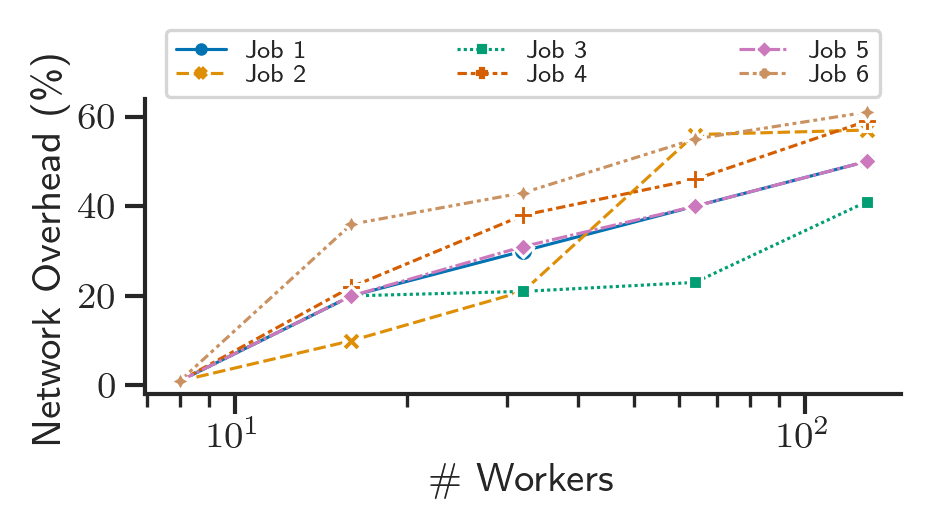

In [169]:
metrics = ['Network Overhead (\%)']
for metric in metrics:
    lineplot(df=df, metric=metric)